# Tabulated Weak Rate Example

Here we walk through an example of a single network consisting of just 2 nuclei linked together by electron-capture and beta-decay.

We'll consider ${}^{56}\mathrm{Ni}$ and ${}^{56}\mathrm{Co}$.  The evolution of this system is:

\begin{align*}
\frac{dY_\mathrm{Ni}}{dt} &= -\lambda_\mathrm{e-cap} Y_\mathrm{Ni} + \lambda_\mathrm{\beta} Y_\mathrm{Co} \\
\frac{dY_\mathrm{Co}}{dt} &= +\lambda_\mathrm{e-cap} Y_\mathrm{Ni} - \lambda_\mathrm{\beta} Y_\mathrm{Co}
\end{align*}

where $Y_\mathrm{Ni}$ and $Y_\mathrm{Co}$ are the molar fractions of the nuclei.

Let's create a network with these rates.

pynucastro will use the tabulated rates from [Langanke & Martinex-Pinedo (2001)](https://www.sciencedirect.com/science/article/abs/pii/S0092640X01908654).

In [2]:
import pynucastro as pyna

In [3]:
tl = pyna.TabularLibrary()
lib = tl.linking_nuclei(["ni56", "co56"])
lib

Ni56 + e⁻ ⟶ Co56 + 𝜈           [Q =   2.92 MeV] (ni56 --> co56 <tabular_tabular>)
Co56 ⟶ Ni56 + e⁻ + 𝜈           [Q =  -2.92 MeV] (co56 --> ni56 <tabular_tabular>)

We'll create a `RateCollection` so we can evaluate the rates easily

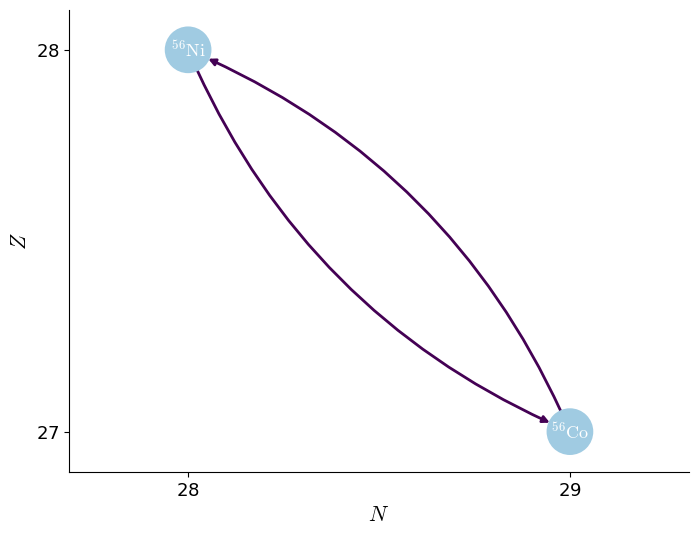

In [7]:
rc = pyna.RateCollection(libraries=[lib])
fig = rc.plot(curved_edges=True)

Let's create a composition -- we'll make equal amounts of Ni and Co

In [9]:
comp = pyna.Composition(rc.unique_nuclei)
comp.set_equal()

We can see from the electron fraction that we are a little neutron-rich

In [10]:
Ye = comp.eval_ye()
Ye

0.4910714285714286

Now let's compute the rates.  We'll pick a density (actually $\rho Y_e$) and temperature
right on one of the points tabulated in the original source so we can directly compare
to what is in the table.

In [11]:
rho = 1.e7 / Ye
T = 1.e9

The rates are proportional to the molar fractions, so we can get those too:

In [12]:
Y = comp.get_molar()
Y

{co56: 0.008928571428571428, ni56: 0.008928571428571428}

Now we can evaluate the rates

In [16]:
rc.evaluate_rates(rho, T, comp)

{Co56 ⟶ Ni56 + e⁻ + 𝜈: 2.6901839501661744e-23,
 Ni56 + e⁻ ⟶ Co56 + 𝜈: 7.240723730837853e-06}

In [14]:
ydots = rc.evaluate_ydots(rho, T, comp)
ydots

{co56: 7.240723730837853e-06, ni56: -7.240723730837853e-06}

If we look at the original tables from Langanke & Martinex-Pinedo (2001), they tabulate (for the conditions we selected above):

```
 neg. daughter Ni56 z=28 n=28 a=56 Q= -1.6240                                           
 pos. daughter Co56 z=27 n=29 a=56 Q=  1.6240                                           
                      +++ Ni56 --> Co56 +++      --- Co56 --> Ni56 ---
   t9   lrho    uf    lbeta+    leps-    lrnu    lbeta-    leps+  lrnubar
...
  1.00  7.0   0.689  -15.299   -3.091   -3.097  -20.521  -23.856  -20.878
...
```

We see that there are 2 rates for ${}^{56}\mathrm{Ni} \rightarrow {}^{56}\mathrm{Co}$: positron decay (`lbeta+`) and electron capture (`leps-`), and 2 rates for ${}^{56}\mathrm{Co} \rightarrow {}^{56}\mathrm{Ni}$: beta-decay (`lbeta-`) and positron capture (`leps+`).  All of these are log base-10 in $\mathrm{s}^{-1}$.

In this case, the dominant rate is the electron capture.  Let's compute that rate manually

In [17]:
lambda_ec = 10.0**-3.091
r = Y[pyna.Nucleus("ni56")] * lambda_ec
r

7.240723730837861e-06

We get the same result as `evaluate_rates()`!

Finally, we can compute the evolution of the electron fraction:
    
$$Y_e = \sum_k Z_k Y_k \ \rightarrow \ \frac{dY_e}{dt} = \sum_k Z_k \frac{dY_k}{dt}$$

In [31]:
dyedt = sum(q.Z * ydots[q] for q in rc.unique_nuclei)
dyedt

-7.240723730837865e-06